In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np
mnist_df = mnist.data.copy()
mnist_df['number'] = mnist.target

In [3]:
mnist_df.to_csv('datasets/mnist.csv',index=False)

In [4]:
X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
y = y.astype(np.uint8)
print(f'X: {X.shape}\ny: {y.shape}')

X: (70000, 784)
y: (70000,)


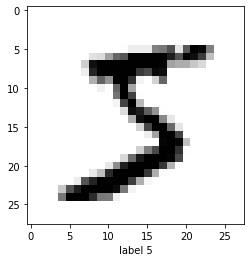

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.xlabel('label ' + str(y[0]))
plt.show()

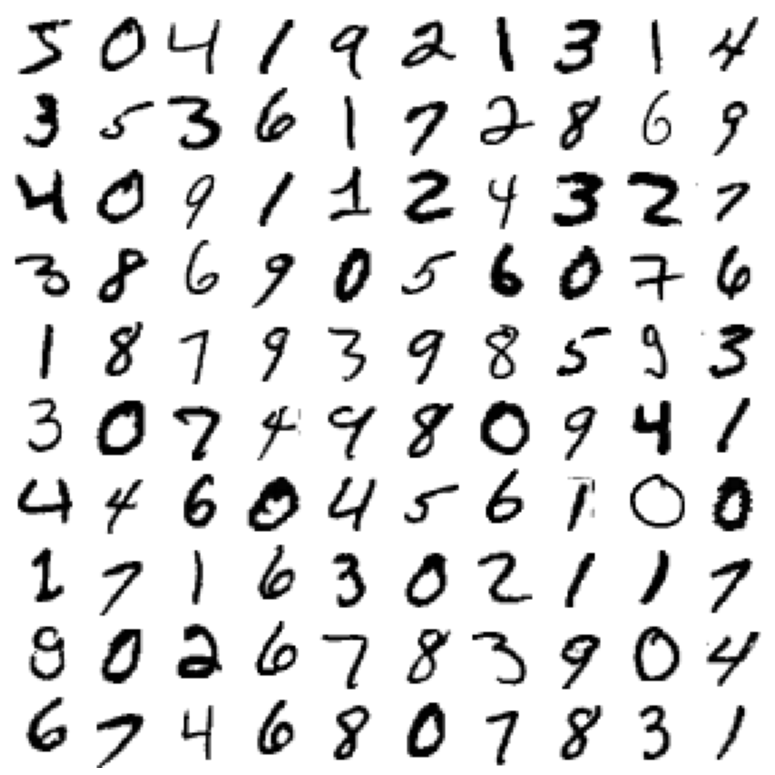

In [6]:
def plot_digits(instances, images_per_row=10):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary)
    plt.axis("off")

examples = X[:100]
plt.figure(figsize=(14,14))
plot_digits(examples, images_per_row=10)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

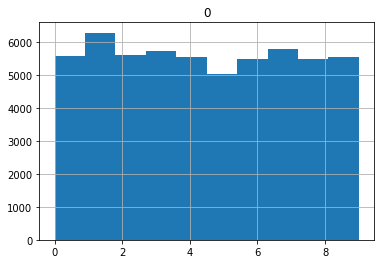

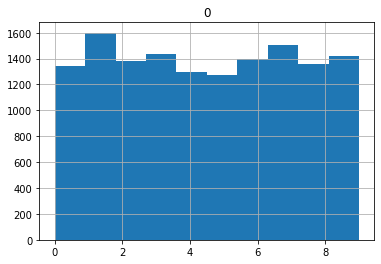

In [8]:
import pandas as pd

pd.DataFrame(y_train).hist()
pd.DataFrame(y_test).hist()

## Training a binary classifier
test if its the number 4

In [9]:
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(n_jobs=4, random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(n_jobs=4, random_state=42)

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_4[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495

0.9342690309101623
0.9795360797128623
0.9747133826208079


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.97883966, 0.97273263, 0.97782064])

In [13]:
from sklearn.base import BaseEstimator

# Base line
class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
cross_val_score(Never4Classifier(), X_train, y_train_4, cv=3, scoring='accuracy')

array([0.90378743, 0.89891252, 0.90110361])

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

# perfect confusion_matrix
confusion_matrix(y_train_4, y_train_4)

array([[50471,     0],
       [    0,  5529]], dtype=int64)

In [16]:
confusion_matrix(y_train_4, y_train_pred)

array([[49782,   689],
       [  629,  4900]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score
print(f'Precision {precision_score(y_train_4, y_train_pred):.2f}\nRecall {recall_score(y_train_4, y_train_pred):.2f}')

Precision 0.88
Recall 0.89


In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_4, y_train_pred)

0.8814534988307251

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

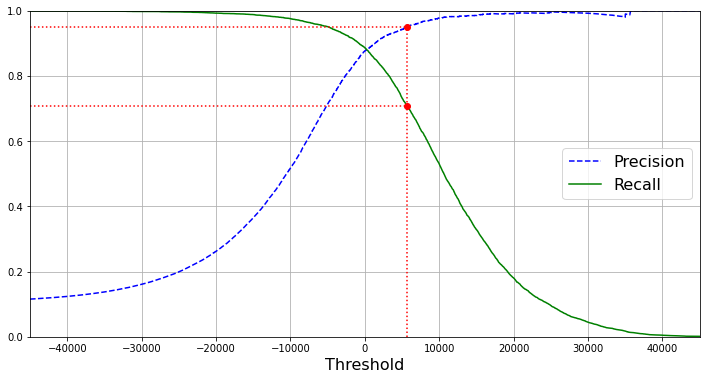

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-45000, 45000, 0, 1])
    
recall_95_precision = recalls[np.argmax(precisions >= 0.95)]
threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]

plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_95_precision, threshold_95_precision], [0., 0.95], "r:")
plt.plot([-45000, threshold_95_precision], [0.95, 0.95], "r:")
plt.plot([-45000, threshold_95_precision], [recall_95_precision, recall_95_precision], "r:")
plt.plot([threshold_95_precision], [0.95], "ro")
plt.plot([threshold_95_precision], [recall_95_precision], "ro")
plt.show()

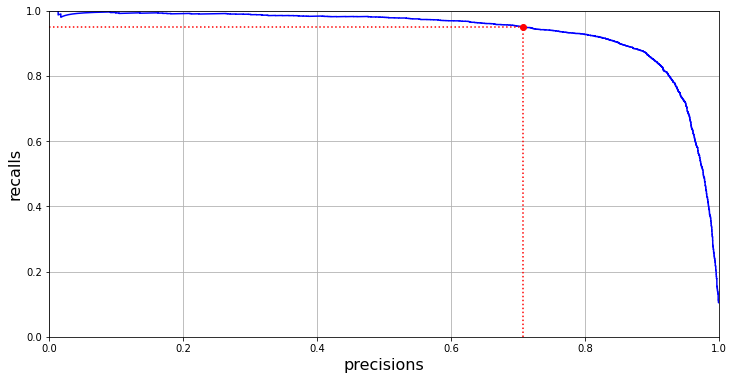

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
    plt.xlabel('precisions', fontsize=16)
    plt.ylabel('recalls', fontsize=16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(12, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_95_precision, recall_95_precision], [0., 0.95], 'r:')
plt.plot([0., recall_95_precision], [0.95, 0.95], 'r:')
plt.plot(recall_95_precision, 0.95, 'ro')
plt.show()

### set precision to 90%

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(f'Precision {precision_score(y_train_4, y_train_pred_90):.2f}/nRecall {recall_score(y_train_4, y_train_pred_90):.2f}')

Precision 0.90/nRecall 0.85


### Receiver Operating Characteristic (ROC)

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

fpr_95 = fpr[np.argmax(tpr >= 0.95)]

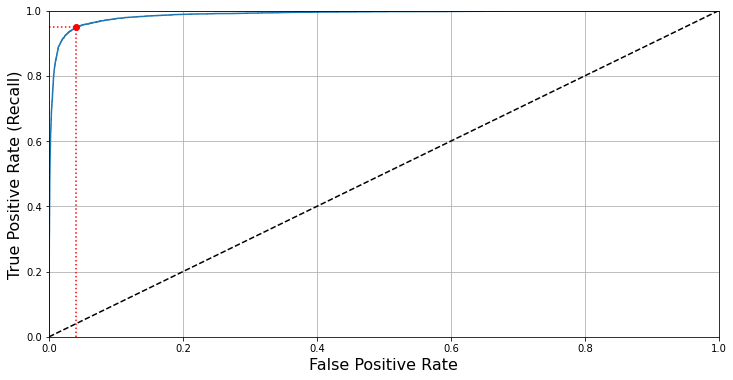

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.plot([0, 1], [0, 1], 'k--')
    
plt.figure(figsize=(12, 6))
plot_roc_curve(fpr, tpr)
plt.plot([fpr_95, fpr_95], [0., 0.95], 'r:')
plt.plot([0., fpr_95], [0.95, 0.95], 'r:')
plt.plot(fpr_95, 0.95, 'ro')
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

print(f'area under the curve (AUC) {roc_auc_score(y_train_4, y_scores):.4f}')

area under the curve (AUC) 0.9881


## RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=4, random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_4, cv=3,
                             method="predict_proba")

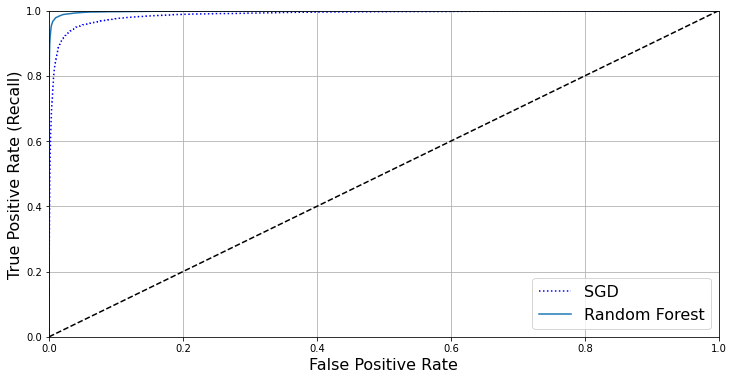

In [27]:
# class probabilities instead of scores
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4, y_scores_forest)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [28]:
print(f'area under the curve {roc_auc_score(y_train_4, y_scores_forest):.4f}')

area under the curve 0.9984


In [29]:
y_train_pred_rf = cross_val_predict(rf_clf, X_train, y_train_4, cv=3, n_jobs=4)
print(f'Precision {precision_score(y_train_4, y_train_pred_rf):.3f}\nRecall {recall_score(y_train_4, y_train_pred_rf):.3f}')

Precision 0.993
Recall 0.873


# Multiclass Classification

In [30]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72162655,  2.72897518,  7.24442535,  8.30613358, -0.31074076,
         9.31386485,  1.71252262,  2.78811966,  6.21099511,  4.86650293]])

In [32]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

force one-vs-rest (takes longer)

In [33]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(), n_jobs=4)
ovr_clf.fit(X_train[:1000], y_train[:1000]) # full set takes very long
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
len(ovr_clf.estimators_)

10

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
sgd_clf.decision_function([some_digit])

array([[-26085.64727654, -34697.24119489,  -4999.4080465 ,
         -1321.53612655, -32246.85587597,   3043.42604314,
        -34493.76916172, -14768.60116179, -10960.21273805,
         -4766.34319641]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=4)

array([0.84212782, 0.87416296, 0.83129755])

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=4)

array([0.91059088, 0.90625167, 0.90147862])

### confusion matrix

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=4)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5290,    0,   15,    8,    8,   38,   40,    6,  154,    1],
       [   1, 5996,   42,   15,    3,   35,    8,   10,  155,   12],
       [  26,   28, 4982,   79,   65,   26,   56,   43,  289,   16],
       [  23,   18,  117, 4951,    2,  188,   23,   38,  288,   60],
       [  11,   17,   43,    6, 4986,   12,   43,   27,  213,  171],
       [  37,   16,   26,  148,   45, 4222,   83,   21,  369,   73],
       [  29,   17,   54,    2,   41,   89, 5134,    4,  110,    0],
       [  18,   16,   64,   20,   44,   10,    5, 5282,  103,  228],
       [  20,   59,   45,   79,    3,  130,   28,    7, 5043,   54],
       [  25,   17,   24,   60,  128,   35,    1,  149,  243, 4856]],
      dtype=int64)

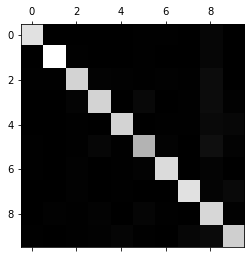

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

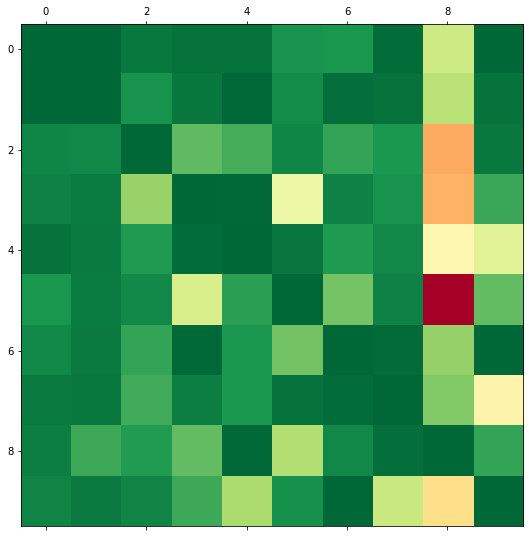

In [41]:
# Normalize the rows by row sum
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#Fill the diagonal with zeros to keep only the errors, and plot the result:

np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(9, 9))
plt.matshow(norm_conf_mx, cmap=plt.cm.RdYlGn_r, fignum=1)
plt.show()

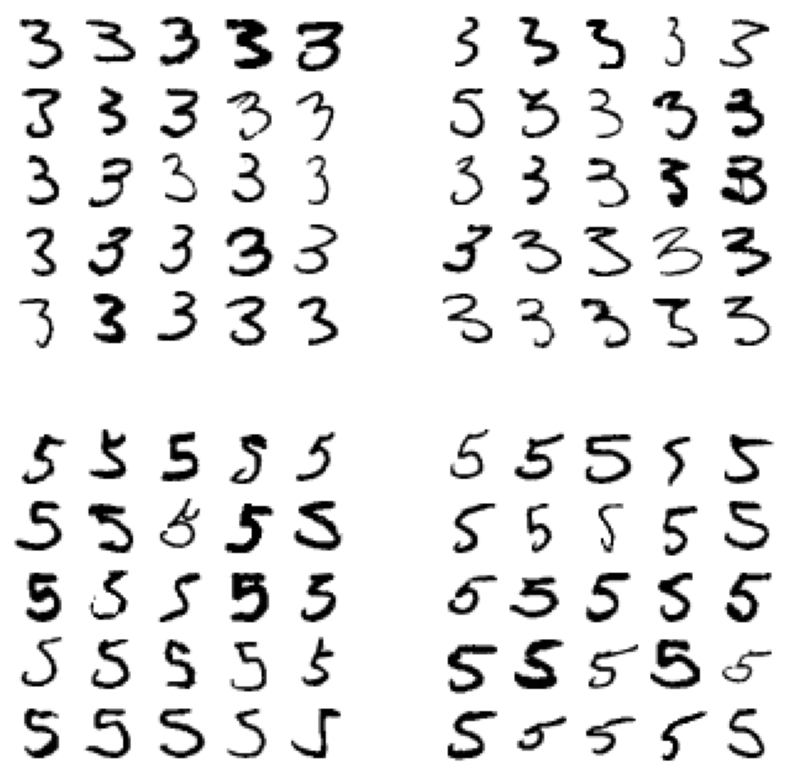

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(14,14))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multiclass with KNeighborsClassifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

param_distrib = {'n_neighbors': list(range(2,10)), 'weights': ['uniform', 'distance']}

knn_clf = KNeighborsClassifier()
rnd_search = RandomizedSearchCV(knn_clf, param_distributions=param_distrib, cv=3, n_jobs=4)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=4,
                   param_distributions={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'weights': ['uniform', 'distance']})

In [61]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'{mean_score:.4f} {params}')

0.9662 {'weights': 'distance', 'n_neighbors': 9}
0.9654 {'weights': 'uniform', 'n_neighbors': 8}
0.9669 {'weights': 'uniform', 'n_neighbors': 4}
0.9607 {'weights': 'uniform', 'n_neighbors': 2}
0.9673 {'weights': 'distance', 'n_neighbors': 2}
0.9690 {'weights': 'distance', 'n_neighbors': 6}
0.9706 {'weights': 'distance', 'n_neighbors': 4}
0.9697 {'weights': 'distance', 'n_neighbors': 3}
0.9677 {'weights': 'distance', 'n_neighbors': 8}
0.9687 {'weights': 'distance', 'n_neighbors': 5}


In [53]:
rnd_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [62]:
rnd_search.best_score_

0.9705892646492343

### data augmentation

In [64]:
from scipy.ndimage.interpolation import shift

def shift_direction(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0),(0,1),(-1,0),(0,-1)):
    for X, y in zip(X_train, y_train):
        X_train_augmented.append(shift_direction(X, dx, dy))
        y_train_augmented.append(y)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [65]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [71]:
y_train_augmented_knn_pred = cross_val_score(knn_clf, X_train_augmented, y_train_augmented, cv=3, n_jobs=-1)

In [73]:
y_train_augmented_knn_pred

array([0.98586796, 0.97739278, 0.97161776])

In [74]:
y_pred = knn_clf.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.9797142857142858


# Multilabel Classification

In [45]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [46]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9759770524441203

# Multioutput Classification

In [47]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

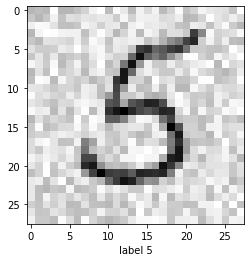

In [48]:
plt.imshow(X_train_mod[0].reshape(28,28), cmap="binary")
plt.xlabel('label ' + str(y[0]))
plt.show()

In [49]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

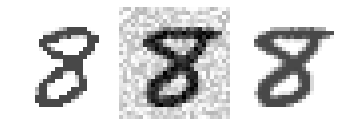

In [50]:
clean_digit = knn_clf.predict([X_test_mod[0]])

plot_digits([clean_digit, X_test_mod[0], y_test_mod[0]], 3)